## All sky proper motion map for Gaia EDR3

This notebook demonstrates the use of the combination of the Gaia archive and python tools to create an all-sky map of the average proper motion of stars, calculated per Healpix pixel, and plotted as streamlines on a sky map.

### Creating the map data with and ADQL query

The mean proper motions can be calculated on the fly as part of an ADQL query in the Gaia archive. The following example query calculates the mean proper motions per healpix (level 5) for stars located in a narrow slice around 1 mas in parallax (nominally 1000 pc in distance).
```
select
  gaia_healpix_index(5, source_id) as healpix_5,
  avg(pmra) as avg_pmra,
  avg(pmdec) as avg_pmdec
from gaiaedr3.gaia_source
where parallax_over_error>=10
and parallax*parallax - 2*parallax - parallax_error*parallax_error < -1
group by healpix_5
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import ArrowStyle

import cartopy.crs as ccrs

from astropy.coordinates import ICRS, Galactic
from astropy.table import Table
import astropy.units as u
import astropy_healpix.healpy as hp

## Plot the mean proper motions as a streamplot on the sky

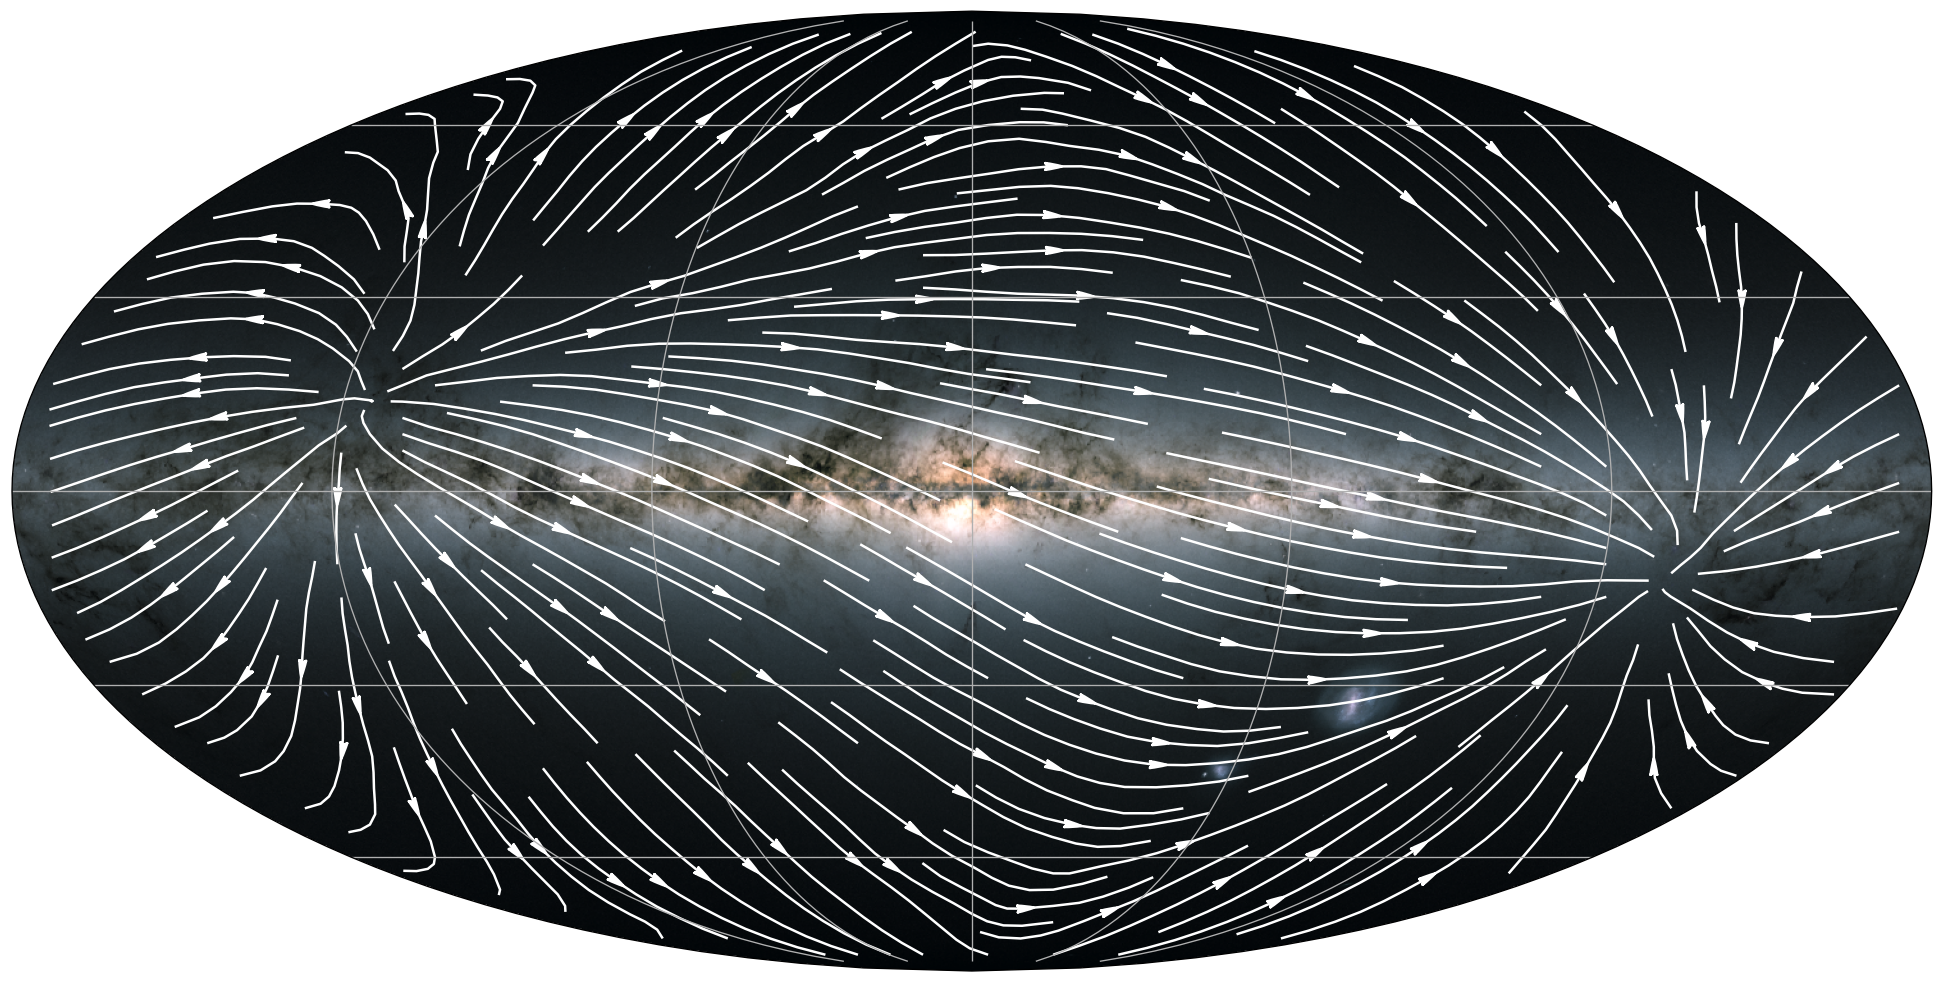

In [2]:
backgr = plt.imread('./data/GaiaSky-colour-2k.png')

defaultProj = ccrs.PlateCarree()
skyProj = ccrs.Mollweide()

# HEALPix parameters
hplevel = 5
nside = hp.order2nside(hplevel)
npix = hp.nside2npix(nside)
hpcol = 'healpix_{0}'.format(hplevel)
filename = "./data/ProperMotionMeansHp5Plx1mas.vot"
edr3data = Table.read(filename)

# Convert HEALPix index to the correct type
hp_indices = np.array(edr3data[hpcol], dtype=int)

# Compute alpha and delta
alpha, delta = hp.pix2ang(nside, hp_indices, lonlat=True, nest=True)
pmra = edr3data['avg_pmra']
pmdec = edr3data['avg_pmdec']

# Define ICRS coordinates with proper motion
icrs = ICRS(
    ra=alpha * u.degree,
    dec=delta * u.degree,
    pm_ra_cosdec=pmra * u.mas / u.yr,
    pm_dec=pmdec * u.mas / u.yr
)

# Transform to Galactic frame
galactic = icrs.transform_to(Galactic())

fig = plt.figure(figsize=(16, 9), dpi=120, frameon=False, tight_layout={'pad': 0.01})
ax = fig.add_subplot(111, projection=skyProj)
ax.imshow(np.fliplr(backgr), transform=defaultProj, zorder=-1, origin='upper')

magnitude = (galactic.pm_l_cosb.value ** 2 + galactic.pm_b.value ** 2) ** 0.5
ax.streamplot(
    galactic.l.value, galactic.b.value, galactic.pm_l_cosb.value, galactic.pm_b.value,
    transform=defaultProj, linewidth=1.5, density=2, color='w', maxlength=0.5, arrowsize=1,
    arrowstyle=ArrowStyle.Fancy(head_length=1.0, head_width=.4, tail_width=.4)
)
ax.gridlines()
ax.invert_xaxis()

plt.show()
